In [35]:
import os
import json
import math
import itertools
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 160)
pd.set_option("display.max_rows", 100)

DATA_PATH = "../data/challenge_data-18-ago.csv"  
FIG_DIR = "../reports/figures"
os.makedirs(FIG_DIR, exist_ok=True)

print('Pandas:', pd.__version__)
print('Numpy :', np.__version__)

Pandas: 2.3.1
Numpy : 2.2.4


In [ ]:
# Cargar CSV con delimitador ';'
df = pd.read_csv(DATA_PATH, sep=';')
assert set(['title','abstract','group']).issubset(df.columns), 'Columnas esperadas no presentes' #comprueba (con una “afirmación”) que en df sí existan las 3 columnas que necesitamos: title, abstract, group.

df.head(5)

,title,abstract,group
0,"Adrenoleukodystrophy: survey of 303 cases: biochemistry, diagnosis, and therapy.",Adrenoleukodystrophy ( ALD ) is a genetically determined disorder associated with progressive central demyelination and adrenal cortical insufficiency . All...,neurological|hepatorenal
1,endoscopy reveals ventricular tachycardia secrets,"Research question: How does metformin affect cancer through pituitary adenoma mechanisms? Methods: randomized controlled study with 53 elderly patients, ass...",neurological
2,dementia and cholecystitis: organ interplay,"Purpose: This randomized controlled study examined statins for diabetes in adult population. The investigation included analysis of bun, cholelithiasis, and...",hepatorenal
3,The interpeduncular nucleus regulates nicotine's effects on free-field activity.,"Partial lesions were made with kainic acid in the interpeduncular nucleus of the ventral midbrain of the rat. Compared with sham-operated controls, lesions ...",neurological
4,guillain-barre syndrome pathways in leukemia,"Hypothesis: statins improves stroke outcomes via migraine pathways. Methods: cross-sectional trial with 285 adult population, measuring astrocytoma and pals...",neurological


In [3]:
n_rows, n_cols = df.shape
info = {
    "num_rows": n_rows,
    "num_cols": n_cols,
    "columns": df.columns.tolist(),
    "missing_values": df.isnull().sum().to_dict(),
    "duplicated_title": int(df['title'].duplicated().sum()),
    "duplicated_abstract": int(df['abstract'].duplicated().sum()),
}
info

{'num_rows': 3565,
 'num_cols': 3,
 'columns': ['title', 'abstract', 'group'],
 'missing_values': {'title': 0, 'abstract': 0, 'group': 0},
 'duplicated_title': 2,
 'duplicated_abstract': 0}

In [ ]:
# Hay 3,565 registros, cada registro tiene 3 columnas: title, abstract, group,
# pero hay 2 filas que aparecen como repetición de un título ya visto.
# NOTA: Puede ser:

#el mismo artículo repetido (mismo título y mismo abstract), o

#mismo título pero abstract diferente (dos estudios con igual título), o

#mismo título con grupos distintos.

In [17]:
# Todas las filas cuyo título está duplicado (muestra ambas apariciones)
dups = df[df['title'].duplicated(keep=False)].sort_values('title')
dups[['title','abstract','group']]


,title,abstract,group
2246,Long term hormone therapy for perimenopausal and postmenopausal women.,BACKGROUND: Hormone therapy (HT) is widely used for controlling menopausal symptoms. It has also been used for the management and prevention of cardiovascul...,neurological|cardiovascular|oncological
2261,Long term hormone therapy for perimenopausal and postmenopausal women.,BACKGROUND: Hormone therapy (HT) is widely used for controlling menopausal symptoms and has also been used for the management and prevention of cardiovascul...,neurological|cardiovascular|oncological
1433,State-of-the-art thiazide diuretics for prostate cancer,"Research question: How does beta-blockers affect cancer through cholestasis mechanisms? Methods: prospective study with 369 cardiac patients, assessing rena...",hepatorenal
3096,State-of-the-art thiazide diuretics for prostate cancer,"Background: cancer affects diabetic patients worldwide, particularly involving arrhythmia and stenosis. Methods: We conducted a randomized controlled study ...",cardiovascular


In [ ]:
#. Aquí hay dos opciones, eliminar la fila duplicada o eliminar la fila duplicada y además fusionar los abstract
# con el mismo título, optaremos por la segunda para un dataset más prolijo

In [21]:
# quita exactos
df_no_exact = df.drop_duplicates(subset=['title','abstract','group']).reset_index(drop=True)

# fusiona por título
tmp = df_no_exact.copy()
tmp['abs_len'] = tmp['abstract'].astype(str).str.split().str.len()

def merge_groups(series):
    joined = '|'.join(series)
    labs = sorted(set([x.strip() for x in joined.split('|') if x.strip()!='']))
    return '|'.join(labs)

df_merged = (tmp.sort_values(['title','abs_len'], ascending=[True, False])
               .groupby('title', as_index=False)
               .agg({'abstract':'first', 'group': merge_groups}))

# 3) reconstruye 'text' 
df_clean = df_merged.copy()
df_clean['text'] = (df_clean['title'].fillna('') + ' ' + df_clean['abstract'].fillna('')).str.strip()
print(len(df), '->', len(df_clean), 'filas tras limpieza')
# Con este script:
# el par “Long term hormone therapy…” se reduce a 1 (porque era exacto).
# el par “State-of-the-art thiazide…” queda en 1 con el abstract más largo y etiquetas unidas.

3565 -> 3563 filas tras limpieza


In [ ]:
# Usar SIEMPRE el dataset limpio a partir de aquí
df = df_clean.copy()
print(len(df))  # verificar que es 3563


3563


In [23]:
# Construir campo 'text' y longitudes (en tokens simples por espacios)
df['text'] = (df['title'].fillna('') + ' ' + df['abstract'].fillna('')).str.strip()
lengths = df['text'].astype(str).apply(lambda s: len(s.split()))

length_stats = {
    "avg_words": float(lengths.mean()),
    "std_words": float(lengths.std()),
    "p50_words": int(lengths.quantile(0.50)),
    "p90_words": int(lengths.quantile(0.90)),
    "p95_words": int(lengths.quantile(0.95)),
    "max_words": int(lengths.max()),
}
length_stats

{'avg_words': 108.72242492281785,
 'std_words': 96.51415235781613,
 'p50_words': 43,
 'p90_words': 261,
 'p95_words': 287,
 'max_words': 535}

In [ ]:
# avg_words = 108.7 → en promedio cada registro tiene ~109 palabras.
#p50_words = 43 → la mitad de los textos tiene ≤ 43 palabras.
#p90 = 261 y p95 = 287 → el 90–95% de los textos tiene ≤ ~260–287 palabras.
#max_words = 535 → el más largo tiene 535 palabras (pocos casos).
# podría funcionar con modelos como BERT. 

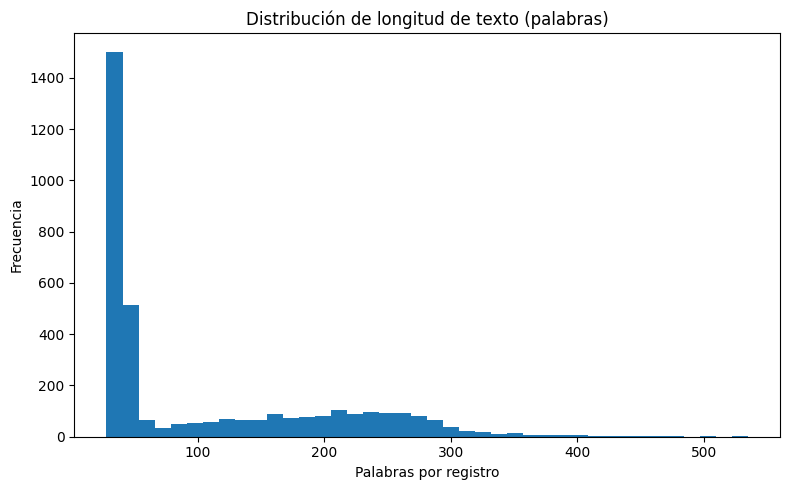

Guardado: ../reports/figures/length_histogram.png


In [25]:
FIG_DIR = "../reports/figures"
os.makedirs(FIG_DIR, exist_ok=True)

plt.figure(figsize=(8,5))
plt.hist(lengths, bins=40)
plt.title("Distribución de longitud de texto (palabras)")
plt.xlabel("Palabras por registro")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/length_histogram.png", dpi=150)
plt.show()

print("Guardado:", f"{FIG_DIR}/length_histogram.png")


In [26]:
lengths = df['text'].astype(str).apply(lambda s: len(s.split()))

bins = [0, 50, 150, 300, np.inf]
bin_labels = ["0–50", "51–150", "151–300", ">300"]

df_len = df.copy()
df_len["len_words"] = lengths.values
df_len["len_bin"] = pd.cut(df_len["len_words"], bins=bins, labels=bin_labels, right=True, include_lowest=True)

df_len["labels_list"] = df_len["group"].astype(str).apply(lambda s: [t.strip() for t in s.split("|")])
classes = sorted({l for L in df_len["labels_list"] for l in L})

print("Bins:", bin_labels)
df_len[["len_words","len_bin"]].head()

Bins: ['0–50', '51–150', '151–300', '>300']


,len_words,len_bin
0,313,>300
1,387,>300
2,206,151–300
3,246,151–300
4,235,151–300


In [ ]:
# La mayoría de los textos son cortos: 0–50 palabras = 2011/3563 (~56%).

# Los muy largos son pocos: >300 palabras = 129 (~3.6%).

In [27]:
from collections import Counter

def is_multilabel(L): 
    return len(L) > 1

summary_by_bin = (
    df_len.groupby("len_bin")
          .agg(
              n_rows = ("len_words","size"),
              avg_len = ("len_words","mean"),
              p95_len = ("len_words", lambda x: np.quantile(x, 0.95)),
              multilabel_ratio = ("labels_list", lambda s: np.mean([is_multilabel(L) for L in s])),
              avg_labels_per_sample = ("labels_list", lambda s: np.mean([len(L) for L in s]))
          )
          .reset_index()
)

summary_by_bin["multilabel_ratio_%"] = (summary_by_bin["multilabel_ratio"]*100).round(1)
summary_by_bin.drop(columns=["multilabel_ratio"], inplace=True)
summary_by_bin


C:\Users\sider\AppData\Local\Temp\ipykernel_30596\1230128677.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_len.groupby("len_bin")


,len_bin,n_rows,avg_len,p95_len,avg_labels_per_sample,multilabel_ratio_%
0,0–50,2011,38.044754,44.0,1.291895,29.2
1,51–150,441,104.013605,146.0,1.285714,24.7
2,151–300,982,223.254582,287.0,1.408350,34.8
3,>300,129,354.759690,474.0,1.503876,41.9


In [28]:
# matriz bin x clase con proporción de presencia de la clase en ese bin
rows = []
for b, g in df_len.groupby("len_bin"):
    total = len(g)
    counts = Counter([lab for L in g["labels_list"] for lab in L])
    row = {"len_bin": b}
    for c in classes:
        row[c] = counts.get(c, 0) / total if total > 0 else 0.0
    rows.append(row)

prev_by_bin = pd.DataFrame(rows).set_index("len_bin").loc[bin_labels]
prev_by_bin.round(3)


C:\Users\sider\AppData\Local\Temp\ipykernel_30596\3782701554.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for b, g in df_len.groupby("len_bin"):


,cardiovascular,hepatorenal,neurological,oncological
len_bin,,,,
0–50,0.421,0.323,0.402,0.146
51–150,0.306,0.288,0.546,0.145
151–300,0.254,0.288,0.646,0.221
>300,0.287,0.248,0.775,0.194


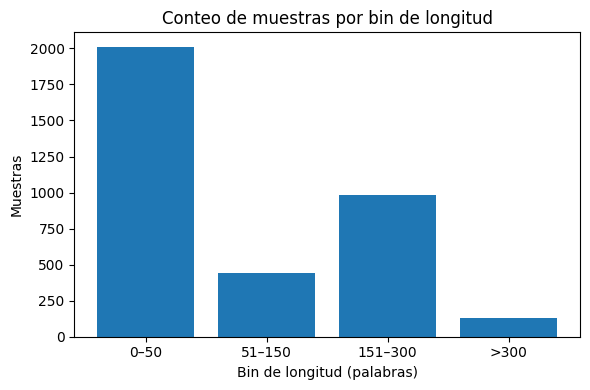

In [29]:

# Conteos por bin
plt.figure(figsize=(6,4))
plt.bar(summary_by_bin["len_bin"].astype(str), summary_by_bin["n_rows"])
plt.title("Conteo de muestras por bin de longitud")
plt.xlabel("Bin de longitud (palabras)")
plt.ylabel("Muestras")
plt.tight_layout()
plt.show()


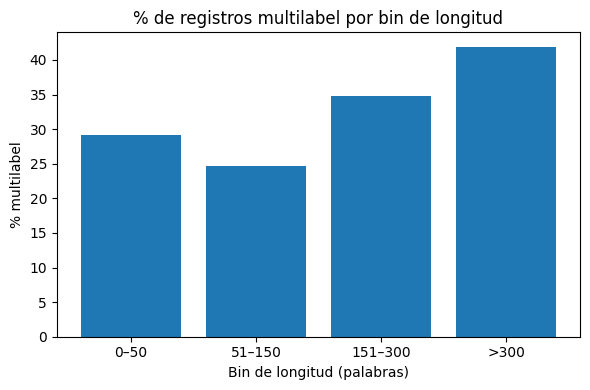

In [30]:
# % Multilabel por bin
plt.figure(figsize=(6,4))
plt.bar(summary_by_bin["len_bin"].astype(str), summary_by_bin["multilabel_ratio_%"])
plt.title("% de registros multilabel por bin de longitud")
plt.xlabel("Bin de longitud (palabras)")
plt.ylabel("% multilabel")
plt.tight_layout()
plt.show()


In [ ]:
# Los textos largos tienden a tener más de una etiqueta; conviene usar umbrales por clase (no uno global).

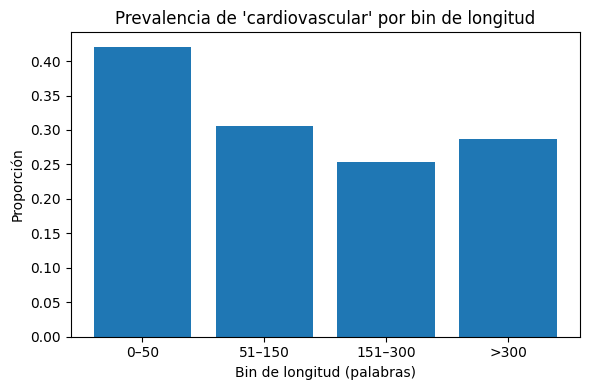

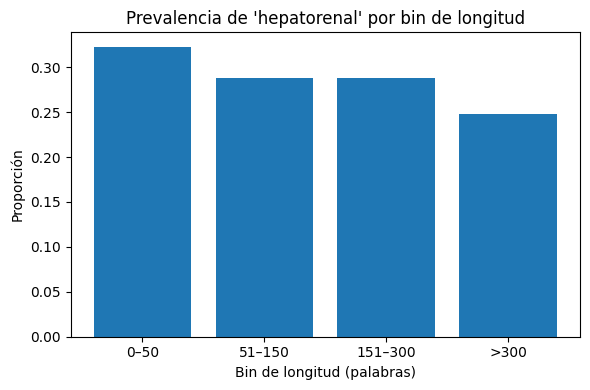

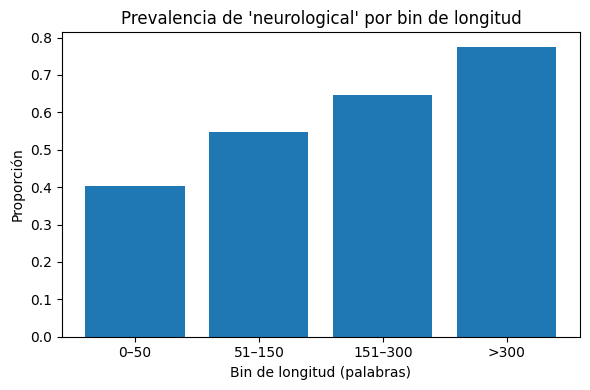

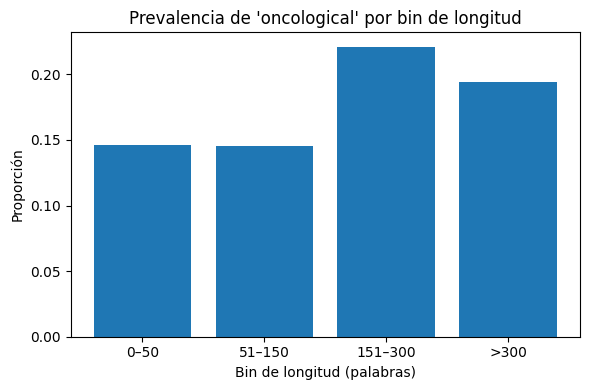

In [31]:
# Prevalencia por clase y bin (un gráfico por clase para que sea legible)
for c in classes:
    plt.figure(figsize=(6,4))
    plt.bar(prev_by_bin.index.astype(str), prev_by_bin[c].values)
    plt.title(f"Prevalencia de '{c}' por bin de longitud")
    plt.xlabel("Bin de longitud (palabras)")
    plt.ylabel("Proporción")
    plt.tight_layout()
    plt.show()


In [ ]:
# Hay correlación longitud↔clase (posible sesgo si los folds no lo reflejan)

In [ ]:

labels_series = df['group'].astype(str).apply(lambda x: [t.strip() for t in x.split('|')])
all_labels = [l for sub in labels_series for l in sub]
label_counts = Counter(all_labels)
classes = sorted(label_counts.keys())

# Estadísticas multilabel
avg_labels_per_sample = sum(len(x) for x in labels_series) / len(labels_series)
multi_label_ratio = sum(1 for x in labels_series if len(x) > 1) / len(labels_series)

summary_labels = {
    "classes": classes,
    "label_counts": dict(label_counts),
    "num_unique_labels": len(classes),
    "avg_labels_per_sample": round(avg_labels_per_sample, 3),
    "multi_label_ratio": round(multi_label_ratio, 3)
}
summary_labels

{'classes': ['cardiovascular', 'hepatorenal', 'neurological', 'oncological'],
 'label_counts': {'neurological': 1785,
  'hepatorenal': 1091,
  'cardiovascular': 1268,
  'oncological': 601},
 'num_unique_labels': 4,
 'avg_labels_per_sample': 1.331,
 'multi_label_ratio': 0.306}

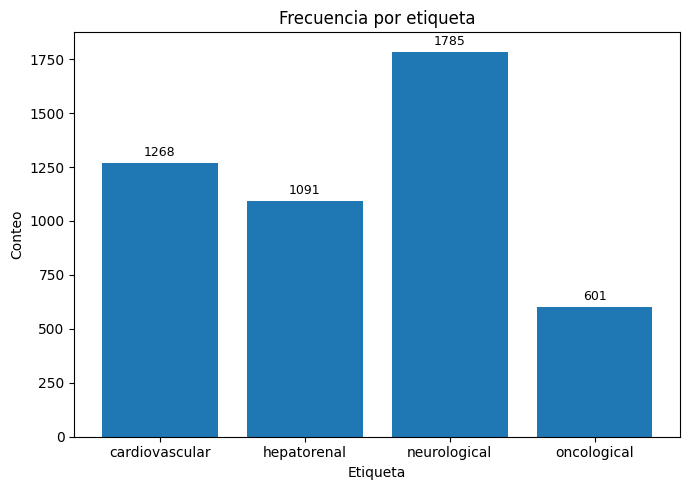

In [7]:
# Barra de frecuencia de etiquetas
labels, counts = zip(*sorted(label_counts.items(), key=lambda x: x[0]))
plt.figure(figsize=(7,5))
plt.bar(labels, counts)
plt.title("Frecuencia por etiqueta")
plt.xlabel("Etiqueta")
plt.ylabel("Conteo")
for i, v in enumerate(counts):
    plt.text(i, v + max(counts)*0.01, str(v), ha='center', va='bottom', fontsize=9, rotation=0)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/label_distribution.png", dpi=150)
plt.show()

In [8]:
# Matriz de co-ocurrencia (conteos)
cls_idx = {c:i for i,c in enumerate(classes)}
cooc = np.zeros((len(classes), len(classes)), dtype=int)

for labs in labels_series:
    idxs = [cls_idx[l] for l in labs if l in cls_idx]
    for i in idxs:
        for j in idxs:
            if i <= j:
                cooc[i,j] += 1
                if i != j:
                    cooc[j,i] += 1

cooc_df = pd.DataFrame(cooc, index=classes, columns=classes)
cooc_df

,cardiovascular,hepatorenal,neurological,oncological
cardiovascular,1268,232,356,97
hepatorenal,232,1091,263,138
neurological,356,263,1785,189
oncological,97,138,189,601


Matriz normalizada (proporciones por fila):


,cardiovascular,hepatorenal,neurological,oncological
cardiovascular,0.649,0.119,0.182,0.050
hepatorenal,0.135,0.633,0.153,0.080
neurological,0.137,0.101,0.688,0.073
oncological,0.095,0.135,0.184,0.586


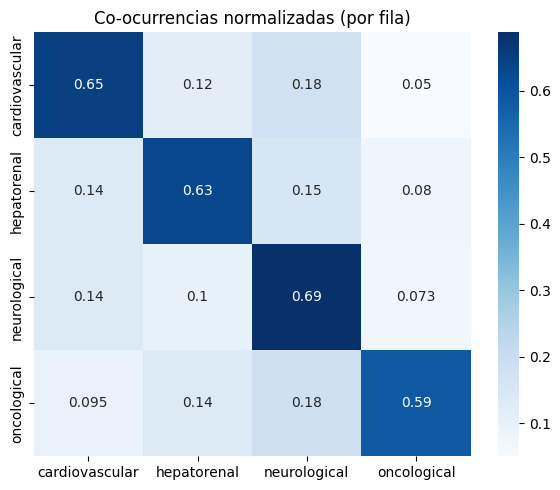

In [32]:
# Normalización por fila (proporción de co-ocurrencia respecto al total de esa clase)
cooc_norm = cooc_df.div(cooc_df.sum(axis=1), axis=0).round(3)

print("Matriz normalizada (proporciones por fila):")
display(cooc_norm)

# Heatmap de proporciones
import seaborn as sns
plt.figure(figsize=(6,5))
sns.heatmap(cooc_norm, annot=True, cmap="Blues", cbar=True)
plt.title("Co-ocurrencias normalizadas (por fila)")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/label_cooccurrence_normalized.png", dpi=150)
plt.show()


In [ ]:
# El dataset no es multiclase puro: ~30–40% de los ejemplos tienen 2 etiquetas. 
# Esto refuerza que el modelo debe manejar multilabel real
#  y que las dependencias entre etiquetas son útiles (ej. usar modelos que capturen correlaciones entre salidas).

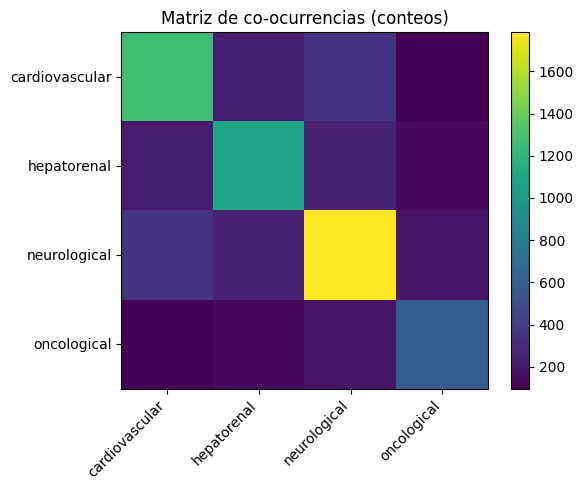

In [9]:
# Mapa de co-ocurrencia
plt.figure(figsize=(6,5))
plt.imshow(cooc, aspect='auto')
plt.colorbar()
plt.xticks(range(len(classes)), classes, rotation=45, ha='right')
plt.yticks(range(len(classes)), classes)
plt.title("Matriz de co-ocurrencias (conteos)")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/label_cooccurrence.png", dpi=150)
plt.show()

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Usamos el campo 'text' ya limpio
texts = df['text']
labels_series = df['group'].astype(str).apply(lambda x: [t.strip() for t in x.split('|')])

# Vectorizador TF-IDF (unigramas y bigramas)
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    stop_words='english'
)
X_tfidf = tfidf.fit_transform(texts)
feature_names = np.array(tfidf.get_feature_names_out())

# Función: top términos por clase
def top_terms_for_class(class_name, top_n=10):
    # índices de textos que contienen esa clase
    idx = [i for i, labs in enumerate(labels_series) if class_name in labs]
    if not idx:
        return pd.DataFrame(columns=["term","score"])
    
    # submatriz
    X_sub = X_tfidf[idx].mean(axis=0).A1
    top_idx = np.argsort(X_sub)[::-1][:top_n]
    return pd.DataFrame({
        "term": feature_names[top_idx],
        "score": X_sub[top_idx].round(3)
    })

# Ejemplo: top 10 palabras por cada clase
for c in classes:
    print(f"\nTop términos para clase '{c}':")
    display(top_terms_for_class(c, top_n=10))



Top términos para clase 'cardiovascular':


,term,score
0,patients,0.042
1,cardiac,0.036
2,heart,0.036
3,results,0.033
4,methods,0.032
5,conclusion,0.031
6,disease,0.031
7,vascular insights,0.030
8,vascular,0.030
9,cancer,0.029



Top términos para clase 'hepatorenal':


,term,score
0,patients,0.040
1,renal,0.035
2,methods,0.030
3,results,0.030
4,conclusion,0.028
5,cancer,0.027
6,disease,0.026
7,liver,0.026
8,organ,0.026
9,study,0.024



Top términos para clase 'neurological':


,term,score
0,patients,0.037
1,results,0.024
2,disease,0.024
3,methods,0.023
4,cancer,0.023
5,study,0.022
6,conclusion,0.021
7,brain,0.020
8,pathways,0.018
9,induced,0.017



Top términos para clase 'oncological':


,term,score
0,cancer,0.084
1,patients,0.040
2,brca1,0.033
3,mutations,0.029
4,breast,0.028
5,tumor,0.026
6,results,0.025
7,methods,0.025
8,conclusion,0.022
9,ovarian,0.022
